In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import timeit
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

### FE parameters for simulations

In [2]:
Ip_params = pd.read_csv('Inputs_4FEparams.csv')

### Import displacement data stored on PC 

In [3]:
samples_xarr_disk = xr.open_dataarray("samples_200_Dummy.nc")
print("Simulation data: \n\n",samples_xarr_disk)

sims_a, times_a, DoFs, Nodes_a = samples_xarr_disk.indexes.values()

Simulation data: 

 <xarray.DataArray (sims: 200, times: 32, DoFs: 3, nodes: 7441)>
[142867200 values with dtype=float32]
Coordinates:
  * sims     (sims) int32 0 1 2 3 4 5 6 7 8 ... 192 193 194 195 196 197 198 199
  * times    (times) float32 0.0 4.998 9.999 15.0 ... 140.0 145.0 150.0 150.0
  * DoFs     (DoFs) object 'x_disp' 'y_disp' 'z_disp'
  * nodes    (nodes) int32 1000001 1000002 1000003 ... 1011767 1011768 1011769


### Initializations

In [4]:
sims_n = 25
ts = len(times_a)                    # No. of Timesteps
no_Nodes = 7441                       # enter number of nodes to run for
Nd = (Nodes_a[0:no_Nodes]).tolist()  # Pick the node IDs of the required number of nodes
standardize = 'True'                 # To standardize add 'True' else add 'False'

In [5]:
X = np.array(Ip_params)              # Input FE parameters
y = samples_xarr_disk                # observations or displacement data from FE simulations

### Test train split of simulation indices 
80% for training and 20% for testing

In [6]:

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
train_idx, test_idx = train_test_split((list(range(sims_n))), test_size=0.2, random_state=42)
print("TRAIN INDEX:", train_idx, "TEST INDEX:", test_idx)

X_df = (pd.DataFrame(X))
X_train = X_df.loc[train_idx, :]
X_test  = X_df.loc[test_idx, :]

y_train = samples_xarr_disk.sel(sims = train_idx, nodes = Nd)
y_test = samples_xarr_disk.sel(sims = test_idx, nodes = Nd)

TRAIN INDEX: [9, 13, 1, 22, 5, 2, 12, 15, 3, 4, 20, 17, 21, 18, 24, 7, 10, 14, 19, 6] TEST INDEX: [8, 16, 0, 23, 11]


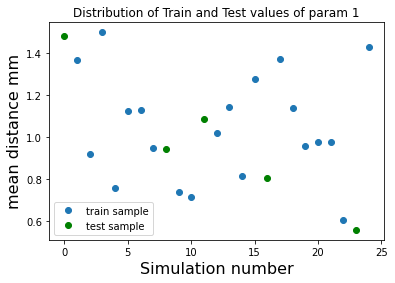

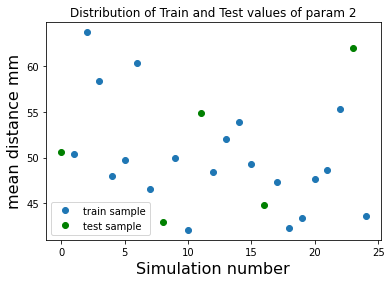

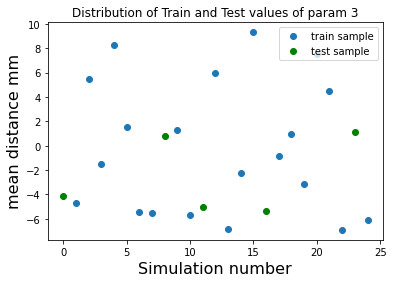

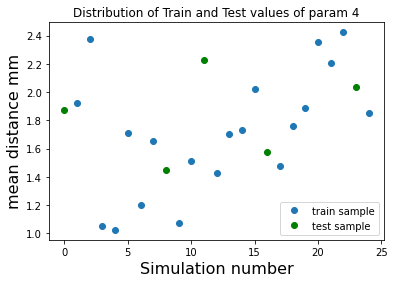

In [7]:
## Plot the distribution of FE parameters from training and testing splits

for b in range(0,4):
    plt.figure()
    plt.title("Distribution of Train and Test values of param {}".format(b+1))
    plt.plot(X_train.iloc[:,b],'o', label='train sample')
    plt.plot(X_test.iloc[:,b],'og', label='test sample')
    plt.xlabel('Simulation number', fontsize = 16)
    plt.ylabel('mean distance mm', fontsize = 16)
    plt.legend(loc='best')
    plt.show()

 ### Get displacement data for PCA in matrix form

In [8]:

start_time = timeit.default_timer()

import get_PCA_y_Data
# from get_PCA_y_Data import get_matrix, get_PCA_y_Data

Matrix1, Matrix2 = get_PCA_y_Data.get_matrix(y_train, train_idx, Nd, ts)
y_test_Mat1, y_test_Mat2 = get_PCA_y_Data.get_matrix(y_test, test_idx, Nd, ts)

Matrix = pd.DataFrame(Matrix2)

elapsed = timeit.default_timer() - start_time
# Print the time taken to generate matrix
print("Time for Matrix generation {} sec".format(elapsed))

Time for Matrix generation 3.175872299999998 sec


### Get PCA data (y_train) for training

In [9]:

PCs_num = 0.99999              # use 0.0 to <1.0 for percentage of variance to be considerered... 
                               #... and integers for number of PCs

start_time = timeit.default_timer()

y_data, n_comps, scaler_std, pca, y_PCA_InvTrans_Data, cum_var = get_PCA_y_Data.get_PCA_y_Data(train_idx, Matrix, standardize, PCs_num, ts)
X_data = X_train

X_train_PCA = X_data
y_train_PCA = y_data

elapsed = timeit.default_timer() - start_time

# Print the time taken to get PCs
print("Time for PCA (s): ", elapsed)

The weights of [1.04678604e+04 7.05584180e+03 3.24645093e+03 6.58604492e+02
 3.01039154e+02 2.11411316e+02 1.23828384e+02 7.14676666e+01
 5.40267372e+01 3.40790977e+01 2.81909904e+01 1.84072895e+01
 1.79836006e+01 1.60764446e+01 1.12893143e+01 7.85131550e+00
 6.43973494e+00 5.00499249e+00 3.82854176e+00 2.74007416e+00
 2.28223658e+00 1.96652329e+00 1.60505521e+00 1.32941616e+00
 1.05200160e+00 8.44719589e-01 7.35854626e-01 6.26904607e-01
 5.86579263e-01 4.92848963e-01 3.88745576e-01 3.71672451e-01
 3.05200338e-01 2.80451804e-01 2.50668854e-01 1.96287870e-01
 1.73616514e-01 1.56682119e-01 1.48452312e-01 1.42784759e-01
 1.21279091e-01 1.15089931e-01 9.62149426e-02 8.95898491e-02
 8.35854933e-02 7.66925439e-02 6.38468862e-02 5.33425957e-02
 5.10399640e-02 4.32054549e-02 4.14683856e-02 3.85589115e-02
 3.70068215e-02 3.20167392e-02 3.08362003e-02 2.79755369e-02
 2.65855417e-02 2.36293823e-02 2.27777660e-02 2.11602431e-02
 1.88995842e-02 1.81032345e-02 1.67599786e-02 1.52472034e-02
 1.458298

#### Random Forest Regression hyperparameter optimization using random search CV

In [26]:
# cv = 10
# kf = KFold(n_splits=cv,  shuffle=True, random_state=50)

# rfr = RandomForestRegressor()

# params_rfr = {'n_estimators':[10,20,30,40,50,100], 
#   'criterion':['mae'], 
#   'max_depth':[5,10,20,25], 
#   'min_samples_split':[2,4,6,8,10],
#   'min_samples_leaf':[2,4,6,8,10],  
#   'max_features':['auto'],
#   'warm_start':['warm_start'],
#   'oob_score':['True','False'],
#   'bootstrap':['True','False']}

# rs_rfr = RandomizedSearchCV(rfr, params_rfr, cv=cv, return_train_score=False, n_iter=100)

# rfr_rsCV = rs_rfr.fit(X_train_PCA, y_train_PCA)
# print('RS_CV Best_params:',rfr_rsCV.best_params_)
# print('RS_CV Results:',pd.DataFrame(rfr_rsCV.cv_results_))

# rfr_best_esti_RS = rfr_rsCV.best_estimator_
# print('RS_CV Best estimators:',rfr_best_esti_RS)

## Random Forest Regression (RFR)

In [27]:
import gpflow
import tensorflow as tf
from gpflow.utilities import print_summary

#### RFR hyperparameters for  25 Simulations sample size

In [33]:
##### For 7441 Nodes

RFR = RandomForestRegressor(bootstrap='True', ccp_alpha=0.0, criterion='mae',
                      max_depth=5, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=2,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=50, n_jobs=None, oob_score='True',
                      random_state=None, verbose=0, warm_start='warm_start')


#### RFR hyperparameters for 50 Simulations sample size

In [34]:
##### For 7441 Nodes

# RFR = RandomForestRegressor(bootstrap='False', ccp_alpha=0.0, criterion='mae',
#                       max_depth=25, max_features='auto', max_leaf_nodes=None,
#                       max_samples=None, min_impurity_decrease=0.0,
#                       min_impurity_split=None, min_samples_leaf=2,
#                       min_samples_split=2, min_weight_fraction_leaf=0.0,
#                       n_estimators=40, n_jobs=None, oob_score='True',
#                       random_state=None, verbose=0, warm_start='warm_start')



#### RFR hyperparameters for 75 Simulations sample size

In [35]:
##### For 7441 Nodes

# RFR = RandomForestRegressor(bootstrap='False', ccp_alpha=0.0, criterion='mae',
#                       max_depth=10, max_features='auto', max_leaf_nodes=None,
#                       max_samples=None, min_impurity_decrease=0.0,
#                       min_impurity_split=None, min_samples_leaf=2,
#                       min_samples_split=4, min_weight_fraction_leaf=0.0,
#                       n_estimators=40, n_jobs=None, oob_score='False',
#                       random_state=None, verbose=0, warm_start='warm_start')


#### RFR hyperparameters for 100 Simulations sample size

In [36]:
##### For 7441 Nodes

#  RFR = RandomForestRegressor(bootstrap='True', criterion='mae', max_depth=25,
#                              min_samples_leaf=6, n_estimators=30,min_samples_split=10, 
#                              oob_score='False', warm_start='warm_start')


### Train RFR model

In [37]:
start_time = timeit.default_timer()

RFR.fit(X_train_PCA, y_train_PCA)

elapsed = timeit.default_timer() - start_time

# Print the time taken to train the RF model
print("Training time (s): ", elapsed)

Training time (s):  5.87497330000042


#### Predict outcome of test set FE parameters using trained RFR model

In [38]:

model = GP_model
pred_model = []
pred_lst = []

for j in range(len(test_idx)):

    test_sim = test_idx[j]
    X_pred = X_test.loc[test_sim].values
    X_pred = X_pred.reshape(1,-1)
    
### Predict the outcomes 
    mean, var = model.predict_f(X_pred) 
    Y_pred = mean+var
    
### Unflatten predicted curve to PCA scores space 
    Y_pred_PC = np.reshape(Y_pred, (n_comps,ts)).T
    
### Inverse transform to sample space as before PCA 
### (Timesteps, XdispsYdispsZdisps of all nodes)
    Y_inv = pca.inverse_transform(Y_pred_PC)
    Y_inv_std = scaler_std.inverse_transform(Y_inv)
    
    pred_lst.append(Y_inv_std)
    pred = Y_inv_std.reshape(ts,3,len(Nd))
    pred_model.append(pred)                       # All predicted test simulation displacements in a list

### Add all predicted outcomes in an xarray format
pred_model_DA = xr.DataArray(pred_model,
                        dims = ["sims","times","DoFs","nodes"],
                        coords = { "sims" : test_idx,
                                  "times" : times_a,
                                  "DoFs"  : ['x_disp', 'y_disp', 'z_disp'],
                                  "nodes" : Nd                                 
                                  })

#### Save Predicted outcomes on PC

In [39]:
# pred_model_DA.to_netcdf("pred_{}Sims_RFR.nc".format(sims_n))

### Calculate Errors of test set prediction against true values 

In [40]:
## Reshape the true and predicted outcomes for calculating errors

test_data = (np.array(y_test)).reshape(y_test.shape[0],y_test.shape[1],
                                                  y_test.shape[2]*y_test.shape[3])

pred_data = (np.array(pred_model_DA)).reshape(pred_model_DA.shape[0],pred_model_DA.shape[1],
                                                  pred_model_DA.shape[2]*pred_model_DA.shape[3])

## Calculate the errors

mean_dist_nds_test = []
mean_mae_nds_test = []
for j in range(0,X_test.shape[0]):
    dist_nds = []
    mae_nds = []
    pred = pred_data[j,:,:].reshape(len(times_a),3,len(Nd))
    # pred = np.array(pred_lst)[j,:,:].reshape(len(times_a),3,no_Nodes)
    true = test_data[j,:,:].reshape(len(times_a),3,len(Nd))
    for k in range(len(Nd)):
        squared_dist = np.sum((true[:,:,k]-pred[:,:,k])**2, axis=1)
        dist = np.sqrt(squared_dist)
        dist_nds.append(dist)
        mae_t = np.mean(abs(true[:,:,k]- pred[:,:,k]), axis=1)
        mae_nds.append(mae_t)
    mean_dist_nds = np.array(dist_nds).mean(axis = 0)
    mean_dist_nds_test.append(mean_dist_nds)
    mean_mae_nds = np.array(mae_nds).mean(axis = 0)
    mean_mae_nds_test.append(mean_mae_nds)

### Error metrics of all test samples 

In [41]:

## Mean absolute error

mae = []
for j in range(0,X_test.shape[0]):
    MAE =  mean_absolute_error(test_data[j,:,:], pred_data[j,:,:])#,multioutput='raw_values')
    mae.append(MAE)
print('Mean Absolute Error of test Simulations:',mae)

## Mean Euclidean Disatnce error

eucd = np.array(mean_dist_nds_test).mean(axis=1)
print('Euclidean Error of test Simulations:',eucd.tolist())

# ## mean square calculation

# mse = []
# for j in range(0,X_test.shape[0]):
#     MSE =  mean_squared_error(test_data[j,:,:], pred_data[j,:,:], squared=True)
#     mse.append(MSE)
# print(mse)

Mean Absolute Error of test Simulations: [2.405501252045971, 1.739215089861252, 1.586205692818352, 6.4510644269365836, 2.1849500874189194]
Euclidean Error of test Simulations: [4.9597119329141055, 3.5633815797949246, 3.288557931782281, 14.403231997244522, 4.538244037954559]


#### Mean error of all nodes of all test predictions

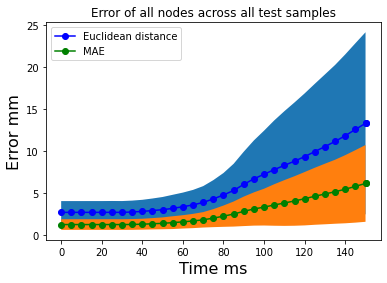

In [42]:
mean_dist_mean = np.array(mean_dist_nds_test).mean(axis=0)
mean_dist_std = np.array(mean_dist_nds_test).std(axis=0)
mean_mae_mean = np.array(mean_mae_nds_test).mean(axis=0)
mean_mae_std = np.array(mean_mae_nds_test).std(axis=0)

plt.figure()
plt.title("Error of all nodes across all test samples")
plt.xlabel('Time ms', fontsize = 16)
plt.ylabel('Error mm', fontsize = 16)
plt.plot(times_a,mean_dist_mean,'o-', color = "b", label= "Euclidean distance")
plt.fill_between(times_a, mean_dist_mean-mean_dist_std, mean_dist_mean+mean_dist_std)
plt.plot(times_a,mean_mae_mean,'o-', color = "g", label= "MAE")
plt.fill_between(times_a, mean_mae_mean-mean_mae_std, mean_mae_mean+mean_mae_std)
plt.legend(loc='upper left')

#### Error of all nodes of test set predictions

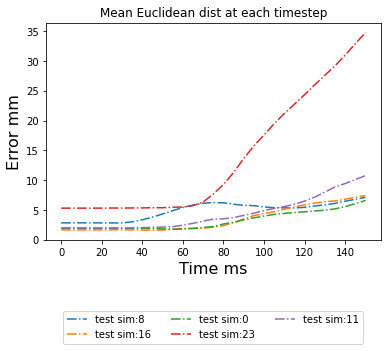

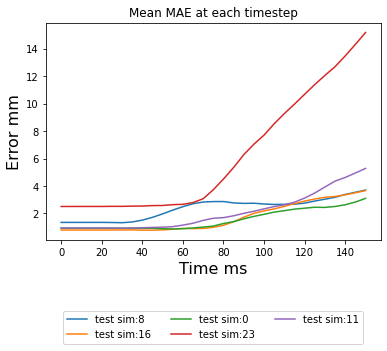

In [43]:
plt.figure()
plt.title("Mean Euclidean dist at each timestep")
plt.xlabel('Time ms', fontsize = 16)
plt.ylabel('Error mm', fontsize = 16)
for c in range(0,len(mean_dist_nds_test)):
    plt.plot(times_a,mean_dist_nds_test[c],'-.', label = "test sim:{}".format(test_idx[c]))
plt.legend(loc='lower center', bbox_to_anchor=(0.5,-0.5), ncol=3)
plt.show()

plt.figure()
plt.title("Mean MAE at each timestep")
plt.xlabel('Time ms', fontsize = 16)
plt.ylabel('Error mm', fontsize = 16)
for c in range(0,len(mean_dist_nds_test)):
    plt.plot(times_a,mean_mae_nds_test[c], label = "test sim:{}".format(test_idx[c]))
plt.legend(loc='lower center', bbox_to_anchor=(0.5,-0.5), ncol=3)
plt.show()

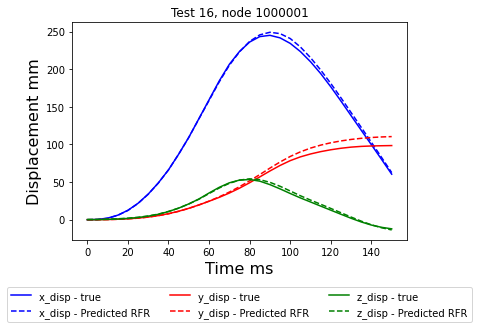

In [44]:
plot_nodes = [1000001]                 # the node IDs for which displacement comparison is to be plot
test_id_plt = test_idx[1]              # the test simulation index from which displacement comparison is to be plot

for i in range(len(plot_nodes)):
    plt.figure()
    plt.title("Test {test}, node {nd}".format(test=test_id_plt, nd=Nd[i]))
    plt.xlabel('Time ms', fontsize = 16)
    plt.ylabel('Displacement mm', fontsize = 16)
    plt.plot(times_a, (samples_xarr_disk.sel(sims = test_id_plt, nodes = plot_nodes[i], 
                                                    DoFs = 'x_disp').values),'b-', label = 'x_disp - true')
    plt.plot(times_a, (pred_model_DA.sel(sims = test_id_plt, nodes = plot_nodes[i], 
                                                    DoFs = 'x_disp').values), 'b--', label='x_disp - Predicted RFR')
    plt.plot(times_a, (samples_xarr_disk.sel(sims = test_id_plt, nodes = plot_nodes[i], 
                                                    DoFs = 'y_disp').values),'r-', label = 'y_disp - true')
    plt.plot(times_a, (pred_model_DA.sel(sims = test_id_plt, nodes = plot_nodes[i], 
                                                    DoFs = 'y_disp').values), 'r--', label='y_disp - Predicted RFR')
    plt.plot(times_a, (samples_xarr_disk.sel(sims = test_id_plt, nodes = plot_nodes[i], 
                                                    DoFs = 'z_disp').values),'g-', label = 'z_disp - true')
    plt.plot(times_a, (pred_model_DA.sel(sims = test_id_plt, nodes = plot_nodes[i], 
                                                    DoFs = 'z_disp').values), 'g--', label='z_disp - Predicted RFR')
    plt.legend(loc='lower center', bbox_to_anchor=(0.5,-0.4), ncol=3)